In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [2]:
import scipy.optimize as spo
import feo_thermodynamics

# FeO nucleation

Abandon equation 2 from Davies et al. as we have the ability to calculate $g^{sl}$ explicitly
as a function of T, P and x (given some assumptions about what happens to O, discussed below).
The following is still ok:

$$ \Delta G = 4/3 \pi r^3 g^{sl} + 4 \pi r^2 \gamma,$$

$$ r_c = \frac{-2 \gamma}{g^{sl}}, $$

(negative $r_c$ implies $g^{sl}$ is positive and we are above the liquidus.)

$$ \Delta G_c = \frac{16 \pi \gamma^3}{{3 g^{sl}}^2} $$

and 

$$ I = I_0 \exp \left[\frac{-\Delta G_c}{k_B T}\right] $$

or

$$ \tau_v = \frac{1}{2 I_0} \exp \left[\frac{\Delta G_c}{k_B T}\right] $$

approximations (beyond the thermodynamic model being right) are that the forward
and backwards reaction rates at the top of the barrier are the same, that $\gamma$
can be taken as a constant, that the crystalizing solid can be described by the bulk
thermodynamics, and that the neucli are spherical.

For an FeO liquid we can calculate the energy of solid HCP Fe and a liquid of any
oxygen content. We can then write:

$$g^{sl} = p g^{solid} + q g(x_p)^{liquid} - (p+q) g(x_i)^{liquid} $$

Where $(p+q)$ moles of liquid of composition $x_i$ freeze to form $p$ moles of HCP iron and 
$q$ moles of residual liquid of composition $x_p$. $p$ can be calculated from the volume of the
critical radius and the molar volume of the solid and $x_i$ is known. The difficulty is 
calculating $q$ and $x_p$. Note also that the volume of the solid and the two liquids differ, 
so that we need to include a PV term, but this is already included in the free energy calculation.


## Well mixed approximation

One approach is to say that as the critical nucleus forms the ejected oxygen becomes well mixed
in a macoscopic system. In this case $g(x_p)^{liquid} = g(x_i)^{liquid}$ and:

$$g^{sl} = g^{solid} - g(x_i)^{liquid} $$

In this approach $g(x_i)^{liquid}$ should be the chemical potential of Fe in the liquid (at $x_i$)
so we do not erroniously count the energy of the oxygen. We are essentially counting the energy
difference of the iron atoms in the well mixed liquid and the same atoms in the solid critical nucleus.


The following uses parameters from Davies et al. but thermodynamics from Komabayashi.


In [3]:
def well_mixed_nucleation(gamma, gsl):
    """
    Calculate CNT parameters assuming pure phase or well mixed liquid
    
    gamma: surface energy (J m^-2)
    gsl: difference between free energy of solid and liquid (J m^-3)
    i0: pre-factor / attempt rate (s^-1 m^-3)
    
    if t > melting temperature, returns np.nan
    
    returns critical radii (in m), free energy barrier (in J), 
    nucleation rate (s^-1 m^3), and waiting time (s m^3)
    """
    # rc
    rc = -2*gamma / gsl
    mask = rc<=0.0 # negative radius is > Tm
    rc[mask] = np.nan
    
    # gc
    gc = (16.0 * np.pi * gamma**3) / (3.0 * gsl**2) # in J?
    gc[mask] = np.nan
    
    return rc, gc
    

In [4]:
def nucleation_rate(t, i0, gc):
    """
    Calculate nucleation rate for CNT given free energy at critical radius
    
    t: temperature (in K)
    i0: pre-factor / attempt rate (s^-1 m^-3)
    gc: free energy of critical radius (J)
    
    returns I (in s^-1 m^-3)
    """
    kb = 1.38064852E-23
    # nuc rate
    i = i0 * np.exp(-gc / (t * kb))
    return i

def waiting_time(t, prefac, gc):
    """
    Calculate waiting time for CNT given free energy at critical radius
    prefac: pre-factor / attempt rate (s m^3) [NB: inverse of i0 above!!!]
    gc: free energy of critical radius (J)
    
    returns tauv (in s m3)
    """
    # FIXME: this is likly to overflow in the exp, even if we precompute
    # prefac = 1/(2 i0). Break up the exp bit?
    kb = 1.38064852E-23
    
    # waiting time
    tauv = prefac*np.exp(gc / (t * kb))
    return tauv

In [5]:
def well_mixed_gsl(x, p, t):
    """
    Free energy change when making solid Fe in liquid FeO
    
    Assumes no O in solid, ideal mixing in liquid...
    
    """
    # All in J/mol
    _, g_fe, _ = feo_thermodynamics.solid_free_energies(x, p, t)
    g_lq = feo_thermodynamics.fe_liquid_chemical_potential(x, p, t)
    _, mol_vol_solid, _ = feo_thermodynamics.solid_molar_volume(1.0, p, t)
    _, partial_mol_vol_liquid, _ = feo_thermodynamics.liquid_molar_volume(1.0, p, t)
    g_sl = g_fe - g_lq # J/mol
    
    g_sl = g_sl  / (mol_vol_solid * 1.0E-6) # J / m^3 of solid
    return g_sl

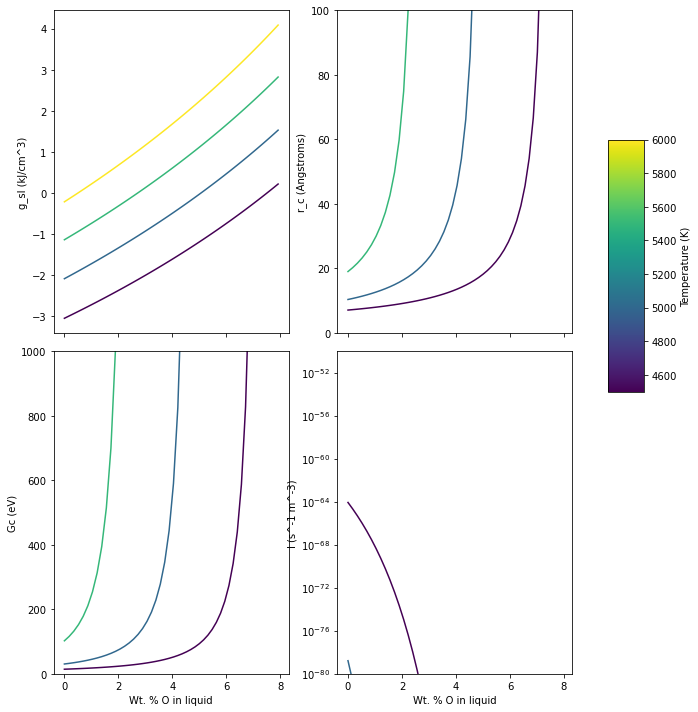

In [6]:
p = 330 # GPa
x = np.linspace(1.0, 0.7) # mol frac Fe
ts = np.array([6000, 5500, 5000, 4500])
gamma = 1.08 # J/m^2
i0 = 0.71E-48 # s^-1 m^-3

fig, ax = plt.subplots(nrows=2, ncols=2, sharex=True, figsize=(10,10))
cmap=matplotlib.cm.ScalarMappable(cmap='viridis')
cmap.set_clim(vmin=min(ts), vmax=max(ts))


for t in ts:
    
    # g_sl
    g_sl  = well_mixed_gsl(x, p, t)
    
    ax[0,0].plot(feo_thermodynamics.mass_percent_o(x), g_sl/(1000*1.0E6), # kJ/cm^3
            color=cmap.to_rgba(t))

    
    # nuc params
    rc, gc = well_mixed_nucleation(gamma, g_sl)
    i = nucleation_rate(t, i0, gc)

    ax[0,1].plot(feo_thermodynamics.mass_percent_o(x), rc/1E-10,
            color=cmap.to_rgba(t))

    ax[1,0].plot(feo_thermodynamics.mass_percent_o(x), 
               gc*6.242e+18, color=cmap.to_rgba(t))
    
    ax[1,1].plot(feo_thermodynamics.mass_percent_o(x), 
               i, color=cmap.to_rgba(t)) 

ax[0,0].set_ylabel('g_sl (kJ/cm^3)')  
ax[0,1].set_ylabel('r_c (Angstroms)')
ax[0,1].set_ylim(0.0, 100.0)
ax[1,0].set_ylabel('Gc (eV)')
ax[1,0].set_ylim(0.0, 1000.0)

ax[1,1].set_ylabel('I (s^-1 m^-3)')
ax[1,1].set_yscale('log')
ax[1,1].set_ylim(1.0E-80,1.0E-50)
ax[1,0].set_xlabel('Wt. % O in liquid')
ax[1,1].set_xlabel('Wt. % O in liquid')



fig.tight_layout()
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.45, 0.05, 0.35])
cbar = fig.colorbar(cmap, cax=cbar_ax)
cbar.set_label('Temperature (K)')
plt.show()

/Users/andreww/miniforge3/envs/py39/lib/python3.9/site-packages/numpy/lib/function_base.py:2197: RuntimeWarning: invalid value encountered in end_member_melting_temperature (vectorized)
  outputs = ufunc(*inputs)
/Users/andreww/miniforge3/envs/py39/lib/python3.9/site-packages/numpy/lib/function_base.py:2197: RuntimeWarning: invalid value encountered in find_liquidus (vectorized)
  outputs = ufunc(*inputs)


19.0340565254156
nan
nan
nan


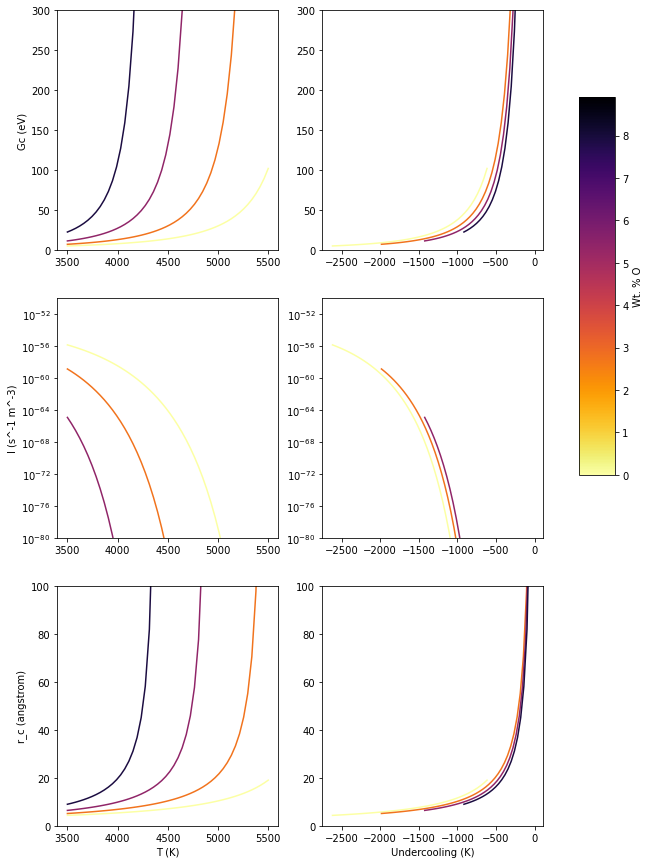

In [7]:
p = 330 # GPa
xs = np.array([1.0, 0.9, 0.8, 0.7]) # mol frac Fe
ts = np.linspace(3500, 5500)
gamma = 1.08 # J/m^2
i0 = 0.71E-48 # s^-1 m^-3

fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(10,15))

cmap=matplotlib.cm.ScalarMappable(cmap='inferno_r')
cmap.set_clim(vmin=feo_thermodynamics.mass_percent_o(max(xs)), 
              vmax=feo_thermodynamics.mass_percent_o(min(xs))+1.0)

for x in xs:
    g_sl = np.zeros_like(ts)
    t_liquidus = feo_thermodynamics.find_liquidus(x, p)
    for i, t in enumerate(ts):
        g_sl[i]  = well_mixed_gsl(x, p, t)
        
    # nuc params
    rc, gc = well_mixed_nucleation(gamma, g_sl) 
    i = nucleation_rate(ts, i0, gc)
    
    ax[0,0].plot(ts, gc*6.242e+18, color=cmap.to_rgba(feo_thermodynamics.mass_percent_o(x)))
    ax[0,1].plot(ts-t_liquidus, gc*6.242e+18, color=cmap.to_rgba(feo_thermodynamics.mass_percent_o(x)))

    ax[1,0].plot(ts, 
               i, color=cmap.to_rgba(feo_thermodynamics.mass_percent_o(x)))
    ax[1,1].plot(ts-t_liquidus, 
               i, color=cmap.to_rgba(feo_thermodynamics.mass_percent_o(x)))
    
    ax[2,0].plot(ts, rc/1E-10, color=cmap.to_rgba(feo_thermodynamics.mass_percent_o(x)))
    ax[2,1].plot(ts-t_liquidus, rc/1E-10, color=cmap.to_rgba(feo_thermodynamics.mass_percent_o(x)))
    print(rc[-1]/1E-10)
    
ax[0,0].set_ylabel('Gc (eV)')
ax[2,0].set_xlabel('T (K)')
ax[2,0].set_ylabel('r_c (angstrom)')
ax[0,0].set_ylim(0, 300)
ax[0,1].set_ylim(0, 300)
ax[2,1].set_xlabel('Undercooling (K)')
ax[1,0].set_ylabel('I (s^-1 m^-3)')
ax[1,0].set_ylim(1.0E-80, 1.0E-50)
ax[1,1].set_ylim(1.0E-80,1.0E-50)
ax[1,0].set_yscale('log')
ax[1,1].set_yscale('log')
ax[2,0].set_ylim(0, 100)
ax[2,1].set_ylim(0, 100)

#fig.tight_layout()
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.45, 0.05, 0.35])
cbar = fig.colorbar(cmap, cax=cbar_ax)
cbar.set_label('Wt. % O')
plt.show()



**Conclusions:**

* We can have a model of nucleation that is self consistent with the thermodynamic model
and includes the effect of oxygen in the liquid.

* In the 'well mixed' case at fixed temperature adding oxygen to the liquid means the undercooling
is smaller, and so the barrier to nucleation grows. This is what is expected from the melting point
depression and accords with the results presented in Davies et al.

* In principle there is an additional effect - iron in the liquid iron-oxygen mixture is less 
stable than iron in pure iron liquid (the $\ln(x)$ term in the chemical potential). This
lowers the barrier to nucleation but this is a very small effect once the melting point
depression has been accounted for.

## Figure for manuscript

Now we just need a figure to show the above for the manuscript. We'll use the
nucleation python module to do the calculations (which is just like the
functions above, but reusable).

In [8]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import nucleation

/Users/andreww/miniforge3/envs/py39/lib/python3.9/site-packages/numpy/lib/function_base.py:2197: RuntimeWarning: invalid value encountered in end_member_melting_temperature (vectorized)
  outputs = ufunc(*inputs)
/Users/andreww/miniforge3/envs/py39/lib/python3.9/site-packages/numpy/lib/function_base.py:2197: RuntimeWarning: invalid value encountered in find_liquidus (vectorized)
  outputs = ufunc(*inputs)


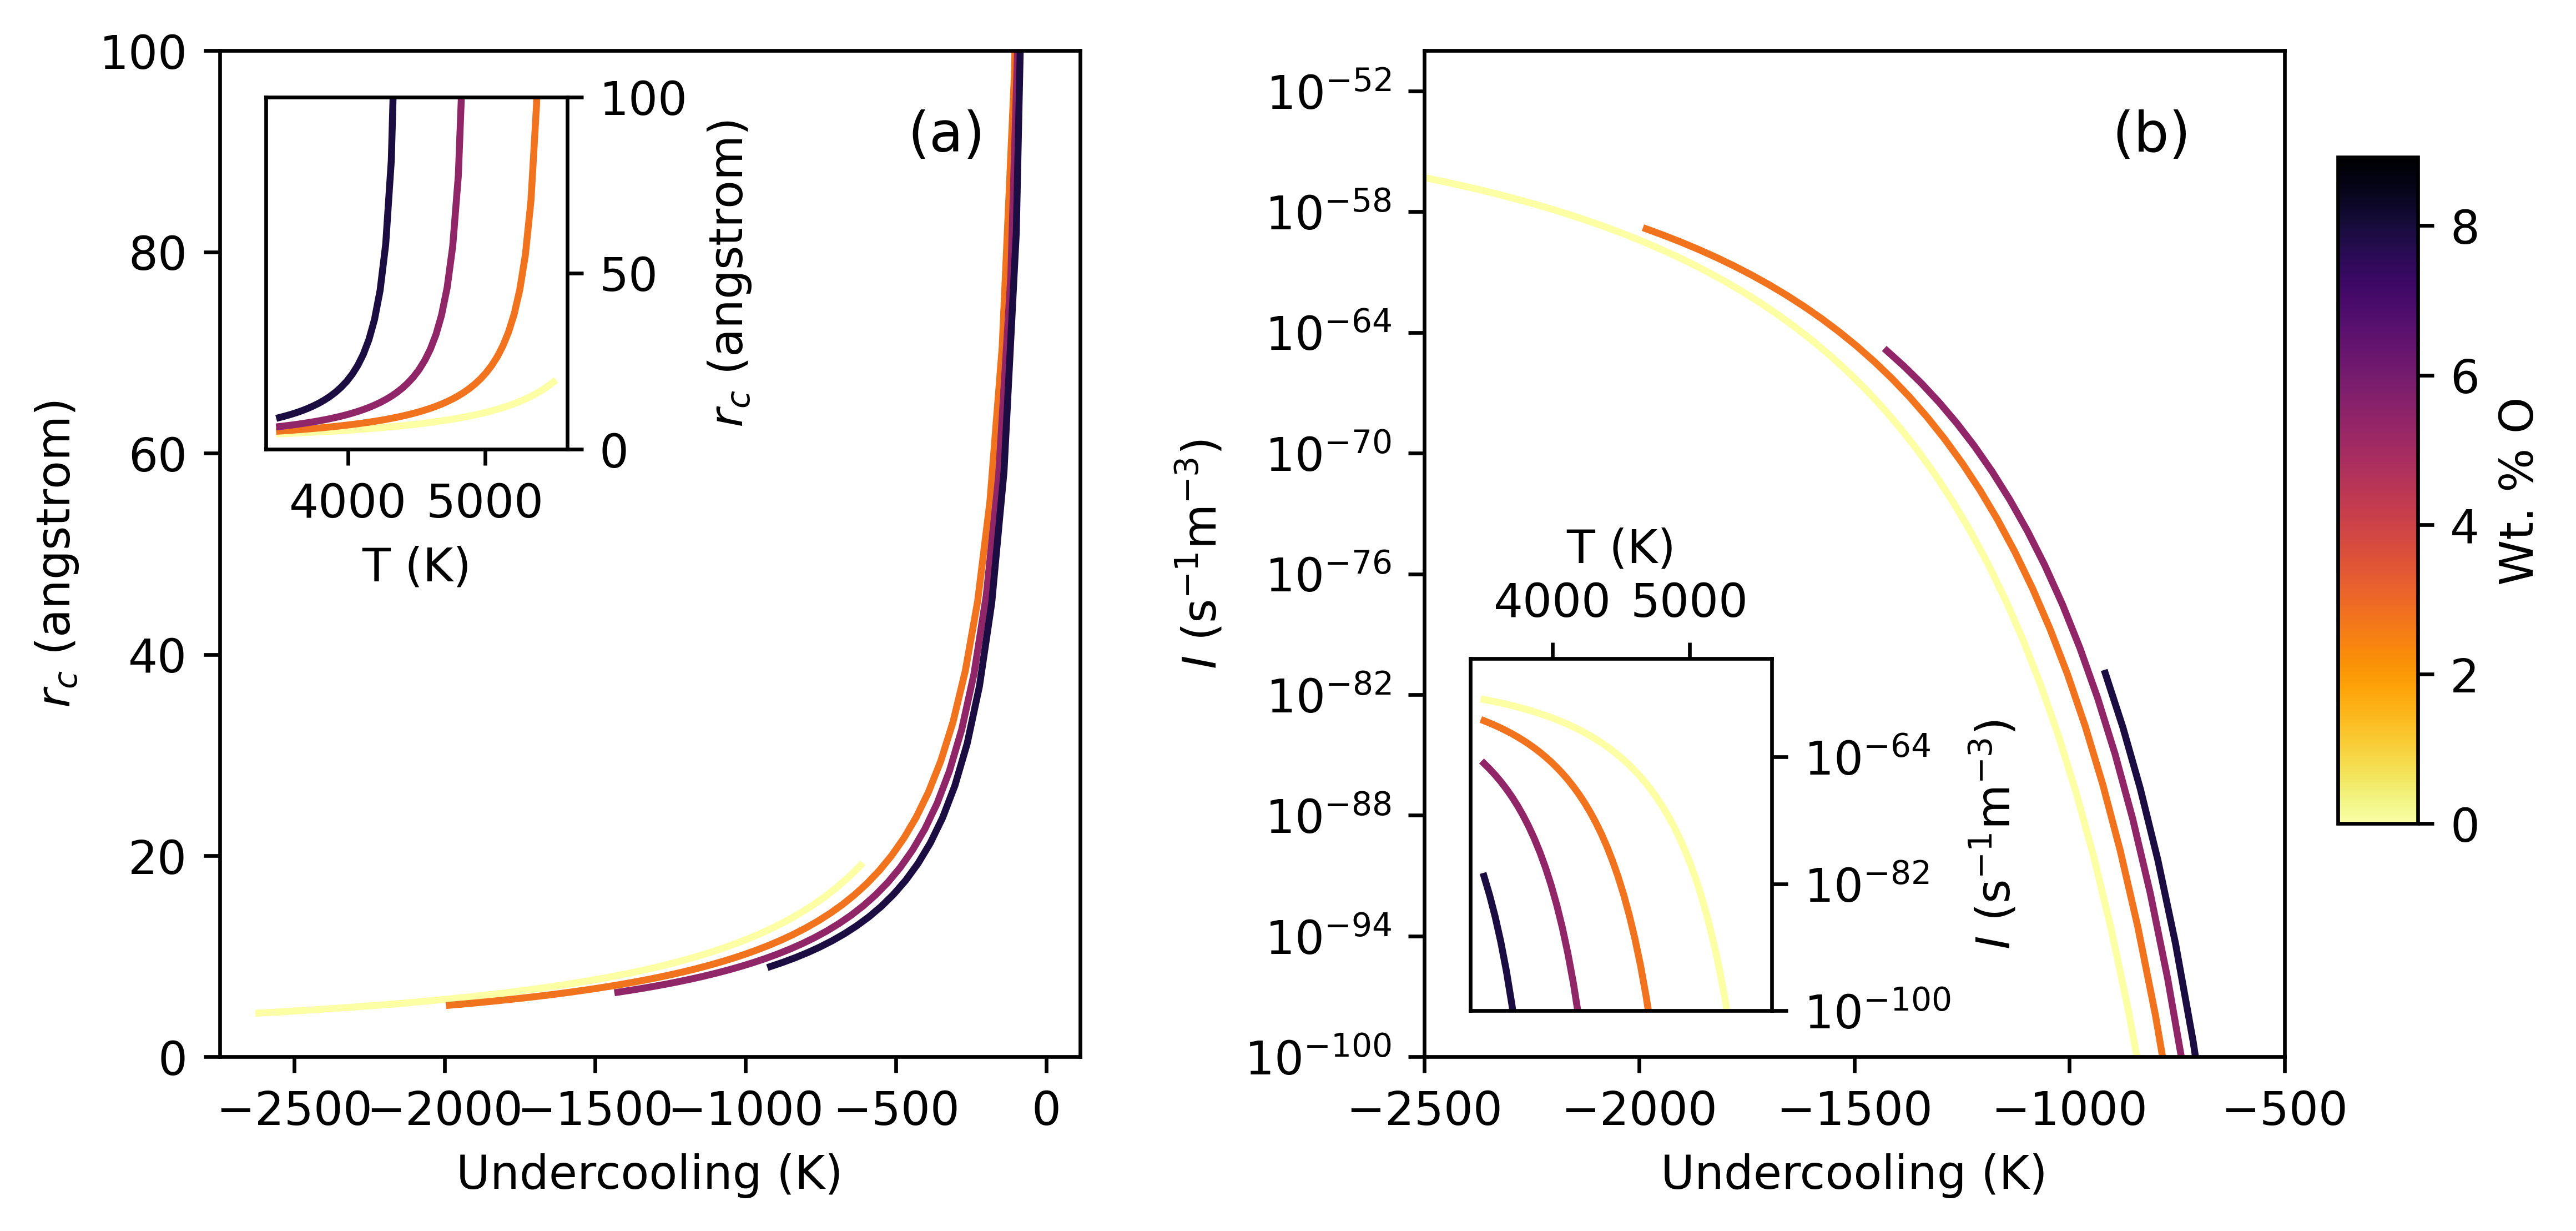

In [22]:
p = 330 # GPa
xs = np.array([1.0, 0.9, 0.8, 0.7]) # mol frac Fe
ts = np.linspace(3500, 5500)
gamma = 1.08 # J/m^2
i0 = 0.71E-48 # s^-1 m^-3

# Our colormap - scale of mass percent O
cmap=matplotlib.cm.ScalarMappable(cmap='inferno_r')
cmap.set_clim(vmin=feo_thermodynamics.mass_percent_o(max(xs)), 
              vmax=feo_thermodynamics.mass_percent_o(min(xs))+1.0)


fig, (axl, axr) = plt.subplots(ncols=2, nrows=1, figsize=(8,4), dpi=600, 
                               gridspec_kw={'wspace':0.4})

axl_ins = inset_axes(axl, width="35%", height="35%", loc=2, borderpad=1)
axr_ins = inset_axes(axr, width="35%", height="35%", loc=3, borderpad=1)


for x in xs:
    t_liquidus = feo_thermodynamics.find_liquidus(x, p) 
    rc_s = np.zeros_like(ts)
    i_s = np.zeros_like(ts)
    for i, t in enumerate(ts):
        rc_, i_, gc_ = nucleation.calc_nucleation(x, p, t, gamma, i0)
        rc_s[i] = rc_
        i_s[i] = i_
        
    axr_ins.plot(ts, i_s, color=cmap.to_rgba(feo_thermodynamics.mass_percent_o(x)))
    axr.plot(ts-t_liquidus, i_s, color=cmap.to_rgba(feo_thermodynamics.mass_percent_o(x)))
    
    axl_ins.plot(ts, rc_s/1E-10, color=cmap.to_rgba(feo_thermodynamics.mass_percent_o(x)))
    axl.plot(ts-t_liquidus, rc_s/1E-10, color=cmap.to_rgba(feo_thermodynamics.mass_percent_o(x)))

axl.set_ylim(0, 100)
axl_ins.set_ylim(0,100)
axl_ins.yaxis.tick_right()
axl_ins.yaxis.set_label_position('right') 


axr.set_ylim(1.0E-100, 1.0E-50)
axr.set_xlim(-2500, -500)
axr_ins.set_ylim(1.0E-100,1.0E-50)
axr.set_yscale("log")
axr_ins.set_yscale("log")
axr_ins.yaxis.tick_right()
axr_ins.xaxis.tick_top()
axr_ins.xaxis.set_label_position('top')
axr_ins.yaxis.set_label_position('right') 

axr_ins.set_xlabel('T (K)')
axl_ins.set_xlabel('T (K)')
axl.set_xlabel('Undercooling (K)')
axr.set_xlabel('Undercooling (K)')
axl.set_ylabel('$r_c$ (angstrom)')
axl_ins.set_ylabel('$r_c$ (angstrom)')
axr.set_ylabel('$I$ (s$^{-1}$m$^{-3}$)')
axr_ins.set_ylabel('$I$ (s$^{-1}$m$^{-3}$)')

cbar_ax = fig.add_axes([0.92, 0.3, 0.03, 0.5])
cbar = fig.colorbar(cmap, cax=cbar_ax)
cbar.set_label('Wt. % O')

axl.annotate("(a)", xy=(0.8, 0.9), xycoords="axes fraction", fontsize='large')
axr.annotate("(b)", xy=(0.8, 0.9), xycoords="axes fraction", fontsize='large')
    
plt.show()